## Imports

In [222]:
from sumedipose_utils import *
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as pyo

## Set variables

In [223]:
main = 1 # Choose between 1 and 6
pair1 = 2 # Choose 2 if main is 1, choose 4 if main is 6
pair2 = 3 # Choose 3 if main is 1, choose 5 if main is 6
subject = 'S4' # You can choose any subject
action = 'A1' # You can choose any action
speed = 'D1' # You can choose any speed
root_path = 'root/path/to/data/' # change this to the path where the data is stored
path1 = f'{root_path}final_data/internal_data_both/C{main}/{subject}/{subject}{action}{speed}.json'
path2 = f'{root_path}final_data/internal_data_both/C{pair1}/{subject}/{subject}{action}{speed}.json'
path3 = f'{root_path}final_data/internal_data_both/C{pair2}/{subject}/{subject}{action}{speed}.json'
index = 0 # Choose any index you want to visualize or use
cal_path = f'{root_path}calibration/external/csvs/test.csv' # path to calibration file
wand_path = f'{root_path}markers_points.json' # path to wand points file
cal_size = 60 # size of the calibration grid


## Get stereo pairs image data

In [224]:
paths = [path1, path2, path3]
image_paths = []
all_cam_points = []
idxs = []
data_3ds = []
for path in paths:
    with open(path, 'r') as f:
        data = json.load(f)
    image_paths.append(f'{root_path}{data[index]["path"]}')
    all_cam_points.append(np.array(data[index]['xy']))
    data_3ds.append(np.array(data[index]['xyz']))
    idxs.append(data[index]['point_ids'])

## View 2D image keypoint data

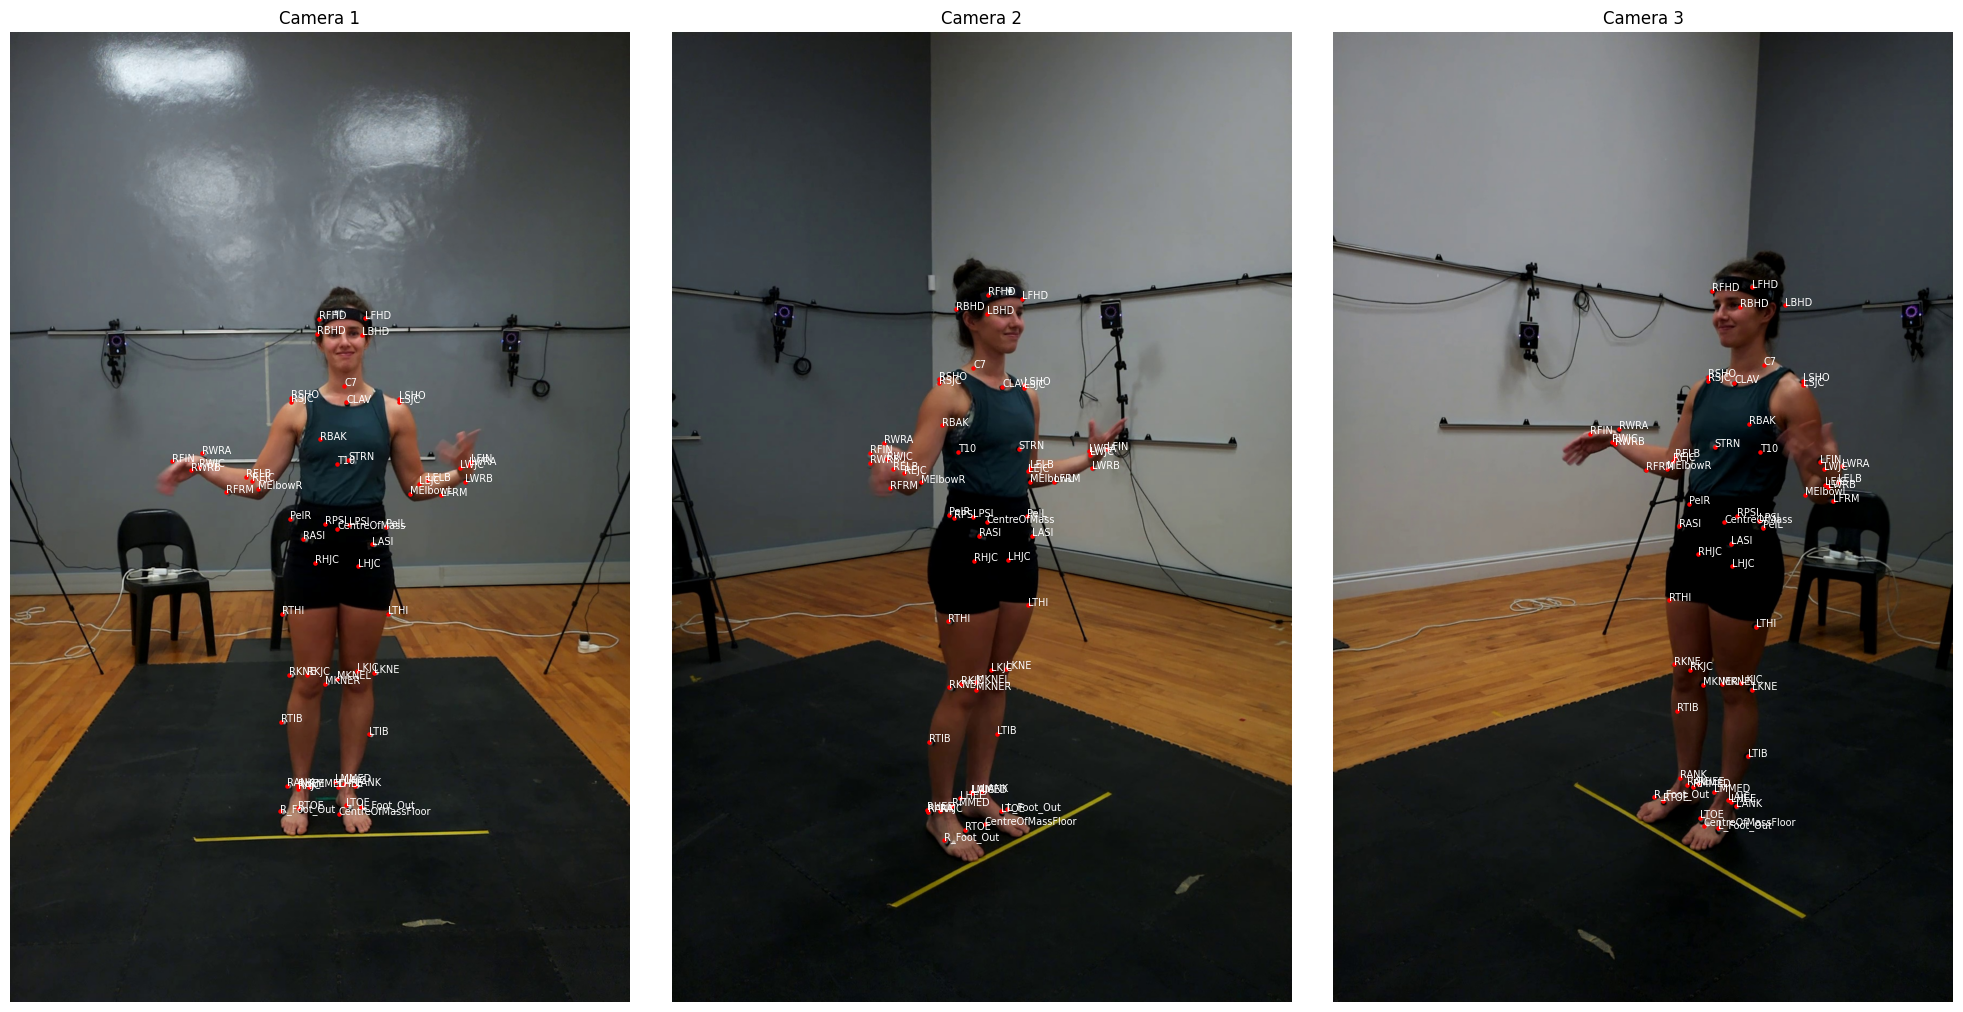

In [225]:
num_images = len(image_paths)
fig, axs = plt.subplots(1, num_images, figsize=(20, 10))

# Loop through each image path and its corresponding keypoints
for ax, path, xy, ids in zip(axs, image_paths, all_cam_points, idxs):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)

    ax.scatter(xy[:, 0], xy[:, 1], c='red', s=5)
    for i, (x, y) in enumerate(xy):
        if x+y > 0:
            ax.text(x, y, ids[i], fontsize=7, color='white')

    ax.axis('off')
    if path == image_paths[0]:
        ax.set_title('Camera 1')
    elif path == image_paths[1]:
        ax.set_title('Camera 2')
    else:
        ax.set_title('Camera 3')

plt.tight_layout()
plt.show()


## Map subjects to camera matrices
The same matrices are used for all the subjects captured within one day and the day is labbled by the first subject captured. This mapping maps all the subjects within the day to the first subject to identify the correct parameters to use.

In [227]:

df_cam_matrix = pd.read_csv(cal_path)

matrix_subjects = df_cam_matrix['subject'].unique().tolist()
matrix_subjects = sorted(matrix_subjects)
matrix_subjects = [int(subj.replace('S', '')) for subj in matrix_subjects]
map_matrix = {}
cur_num = 1
for i in range(1,29):
    if i in matrix_subjects:
        cur_num = i
    map_matrix[f'S{i}'] = f'S{cur_num}'

## Load camera matrices for specific subject
You can choose to load both stereo pairs or just one

In [228]:
cal_path_pair1 = df_cam_matrix[(df_cam_matrix['main'] == main) & (df_cam_matrix['pair'] == pair1) & (df_cam_matrix['subject'] == map_matrix[subject])]['path'].values[0]
cal_path_pair2 = df_cam_matrix[(df_cam_matrix['main'] == main) & (df_cam_matrix['pair'] == pair2) & (df_cam_matrix['subject'] == map_matrix[subject])]['path'].values[0]

## Load stereo calibration pairs camera matrices
1. Load data
2. Extract rotation matrix, R, and translation vector, t
3. Calculate each camera's projection matrix, P

Note: Origin/main camera will always be origin/0-values

In [229]:
data_pair1 = np.load(cal_path_pair1)
data_pair2 = np.load(cal_path_pair2)

R1 = np.eye(3)  
T1 = np.array([0, 0, 0])  
R2 = data_pair1['R']
T2 = data_pair1['T']
T2 = np.array([T2[0][0], T2[1][0], T2[2][0]]).reshape((3,1))
R3 = data_pair2['R']
T3 = data_pair2['T']
T3 = np.array([T3[0][0], T3[1][0], T3[2][0]]).reshape((3,1))

R1_initial = R1.copy()
T1_initial = T1.reshape((3,1)).copy()
R2_initial = R2.copy()
T2_initial = T2.reshape((3,1)).copy()
R3_initial = R3.copy()
T3_initial = T3.reshape((3,1)).copy()

cameraMatrix1 = data_pair1['mtx_A']
cameraMatrix2 = data_pair1['mtx_B']
cameraMatrix3 = data_pair2['mtx_B']

RT1 = np.concatenate([R1, [[0],[0],[0]]], axis = -1)
P1 = cameraMatrix1 @ RT1
RT2 = np.concatenate([R2, T2], axis = -1)
P2 = cameraMatrix2 @ RT2
RT3 = np.concatenate([R3, T3], axis = -1)
P3 = cameraMatrix3 @ RT3

Ps = [P1, P2, P3]


## Project 2D pixel keypoints -> 3D
- Stereo pairs include one main/origin cameras and two pair cameras
- You can choose to project using all three cameras, or only two cameras: 
   1. main/origin camera & pair 1 & pair 2
   2. main/origin camera & pair 1
   2. main/origin camera & pair 2

In [230]:
preds = []
for i, (all_cam_point, ids) in enumerate(zip(all_cam_points, idxs)):
    new_xy = []
    new_ids = []
    for id, xy in zip(ids, all_cam_point):
        if np.isnan(xy).any():
            continue
        else:
            new_xy.append(xy)
            new_ids.append(id)
    all_cam_points[i] = new_xy
    idxs[i] = new_ids

# DLT using 3 cameras
points = np.array(DLT_3_cameras(all_cam_points[0], all_cam_points[1], all_cam_points[2], Ps[0], Ps[1], Ps[2]))
preds.append(points)

# DLT using 2 cameras (main/origin camera & pair 1)
points = np.array(DLT_2_cameras(all_cam_points[0], all_cam_points[1], Ps[0], Ps[1]))
preds.append(points)

# DLT using 2 cameras (main/origin camera & pair 2)
points = np.array(DLT_2_cameras(all_cam_points[0], all_cam_points[2], Ps[0], Ps[2]))
preds.append(points)


## Visualize predicted 3D projection vs ground truth 3D data

(61, 3)
(61, 3)
(61, 3)


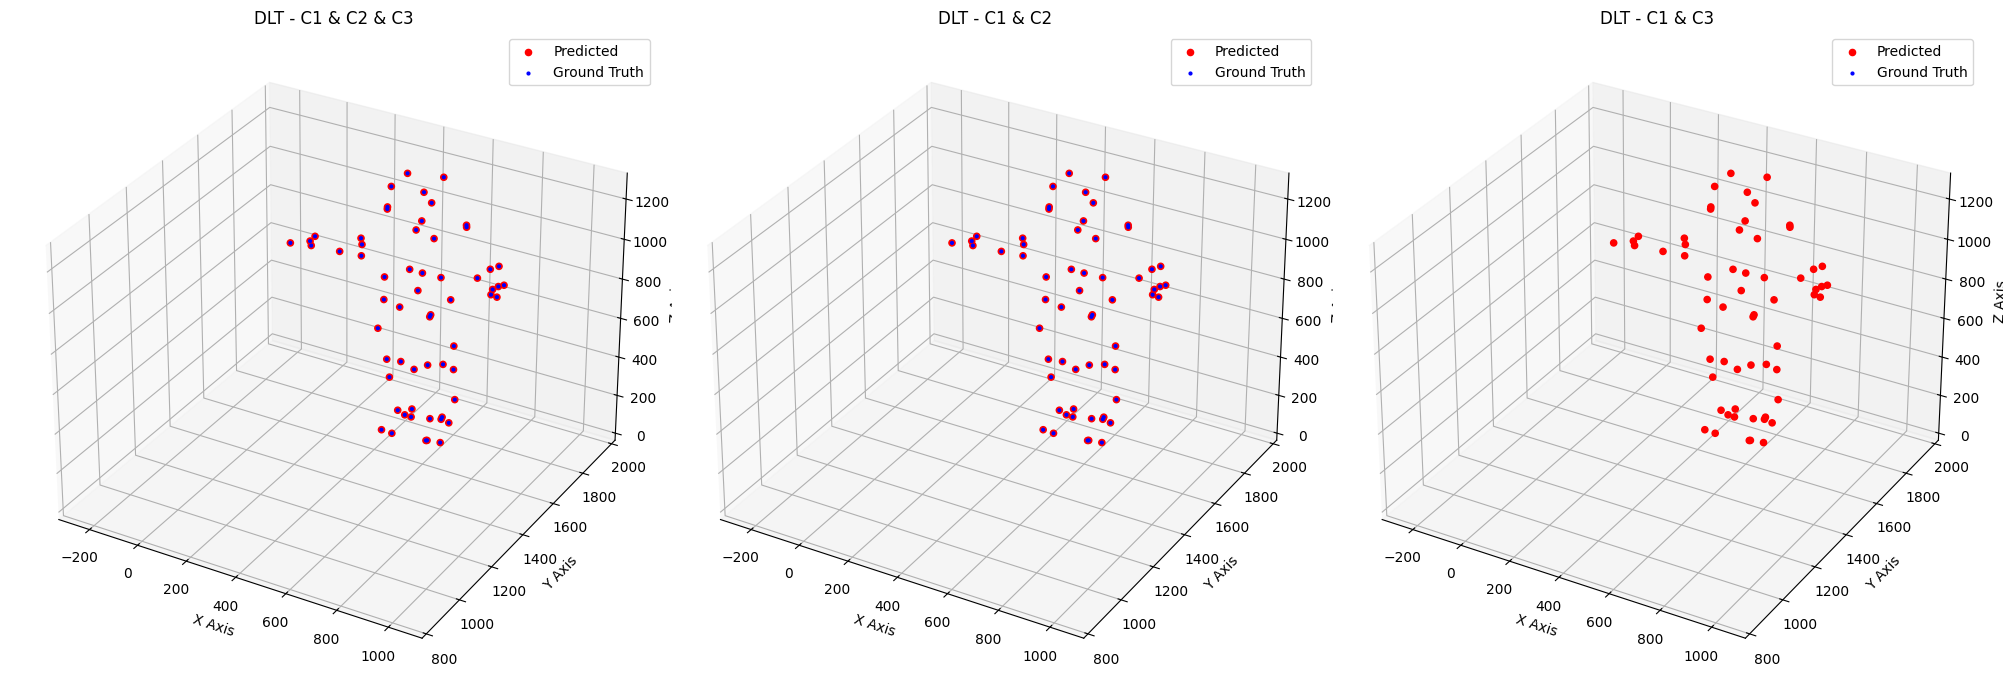

In [231]:
fig = plt.figure(figsize=(20, 10))  

for i, pred in enumerate(preds[:3]):
    data = pred.copy()

    # Extract x, y, z coordinates for predicted data
    x = data[:, 0] * cal_size
    z = -data[:, 1] * cal_size
    y = data[:, 2] * cal_size

    # Extract x, y, z coordinates for ground truth
    x_gt = data_3ds[0][:, 0] * cal_size
    z_gt = -data_3ds[0][:, 1] * cal_size
    y_gt = data_3ds[0][:, 2] * cal_size

    # Create a 3D subplot
    ax = fig.add_subplot(1, 3, i + 1, projection='3d') 

    # Plot predicted data points in 3D
    ax.scatter(x, y, z, c='r', marker='o', alpha=1, label='Predicted')
    # Plot ground truth data points in 3D
    ax.scatter(x_gt, y_gt, z_gt, c='b', marker='o', alpha=1, s=4, label='Ground Truth')    

    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_xlim(-300, 1100)
    ax.set_ylim(800, 2000)
    ax.set_zlim(-10, 1300)
    ax.legend()
    if i == 0:
        ax.set_title(f'DLT - C1 & C2 & C3')
    elif i == 1:
        ax.set_title(f'DLT - C1 & C2')
    else:
        ax.set_title(f'DLT - C1 & C3')

plt.tight_layout()
plt.show()

## Interactive 3D data view with cameras

In [232]:
data = points.copy()  # Replace with your actual points

# Extract x, y, z coordinates
x = data[:, 0] * cal_size
y = data[:, 1] * cal_size
z = data[:, 2] * cal_size

# Create the 3D scatter plot using plotly
trace = go.Scatter3d(
    x=x*1,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=5, color='red', opacity=1),
    name='Predicted'
)

# add 3d data
trace_gt = go.Scatter3d(
    x=data_3ds[0][:, 0]*cal_size,
    y=data_3ds[0][:, 1]*cal_size,
    z=data_3ds[0][:, 2]*cal_size,
    mode='markers',
    marker=dict(size=3, color='black', opacity=1),
    name='Ground Truth'
)

#add T1
trace_T1 = go.Scatter3d(
    x=[0],
    y=[0],
    z=[0],
    mode='markers',
    marker=dict(size=10, color='green', opacity=1),
    name='C1'
)
#add T2
trace_T2 = go.Scatter3d(
    x=[T2[0][0]*cal_size],
    y=[T2[1][0]*cal_size],
    z=[T2[2][0]*cal_size],
    mode='markers',
    marker=dict(size=10, color='blue', opacity=1),
    name='C2'
)
#add T3
trace_T3 = go.Scatter3d(
    x=[T3[0][0]*cal_size],
    y=[T3[1][0]*cal_size],
    z=[T3[2][0]*cal_size],
    mode='markers',
    marker=dict(size=10, color='yellow', opacity=1),
    name='C3'
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X Axis', range=[-2000, 2000]),
        yaxis=dict(title='Y Axis', range=[-1000, 1000]),
        zaxis=dict(title='Z Axis', range=[-15, 3000])
    ),
    width=1000,
    height=1000
)

# Create the figure
fig = go.Figure(data=[trace, trace_gt, trace_T1, trace_T2, trace_T3], layout=layout)

def plot_vector(fig, start, direction, name, color):
    end = start + direction
    fig.add_trace(go.Scatter3d(x=[start[0], end[0]], y=[start[1], end[1]], z=[start[2], end[2]],
                            mode='lines+text', line=dict(color=color, width=5), name=name))
    
colors = ['red', 'green', 'blue']  # Colors for the x, y, z axis directions
axis_names = ['X-rotation', 'Y-rotation', 'Z-rotation']  # Names for the x, y, z axis directions
for i in range(3):
    direction = R1[:, i]*500
    plot_vector(fig, T1.flatten(), direction, f'{axis_names[i]} (C1)', colors[i])
for i in range(3):
    direction = R2[:, i]*500
    plot_vector(fig, cal_size*T2.flatten(), direction, f'{axis_names[i]} (C2)', colors[i])
for i in range(3):
    direction = R3[:, i]*500
    plot_vector(fig, cal_size*T3.flatten(), direction, f'{axis_names[i]} (C3)', colors[i])

# Save the figure as an offline HTML file
pyo.plot(fig, filename='3d_scatter_plot.html')


'3d_scatter_plot.html'